In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_textbook.problems import grover_problem_oracle
from numpy import pi
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import MCXGate
from qiskit import QuantumCircuit

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
def Oracle(qc,solution,nqubits):
    
    #Gets binary format of solution
    solbin = "{0:b}".format(solution)
    ls = len(solbin)
    
    #If binary is shorter than the register add 0s to MSB to match length
    if ls<nqubits:
        for i in range(nqubits-ls):
            solbin = "0"+solbin
    
    i = j = nqubits-1
    
    #Puts X gates on qubits that must give output 0
    for x in solbin:
        if x=="0":
            qc.x(i)
        i -= 1
    
    #Multi-controlled Z gate using Hadamards and MCT
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    
    #Puts X gates on qubits that must give output 0
    for x in solbin:
        if x=="0":
            qc.x(j)
        j -= 1
    
    qc.barrier()

In [3]:
def Diffuser(qc,nqubits):
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    for qubit in range(nqubits):
        qc.x(qubit)
    
    #Multi-controlled Z gate using Hadamards and MCT
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)

    for qubit in range(nqubits-1):
        qc.barrier(qubit)

    for qubit in range(nqubits):
        qc.x(qubit)
    
    for qubit in range(nqubits):
        qc.h(qubit)
        
    qc.barrier()

In [4]:
#Change for different circuits
nqubits = 3
solution = 5

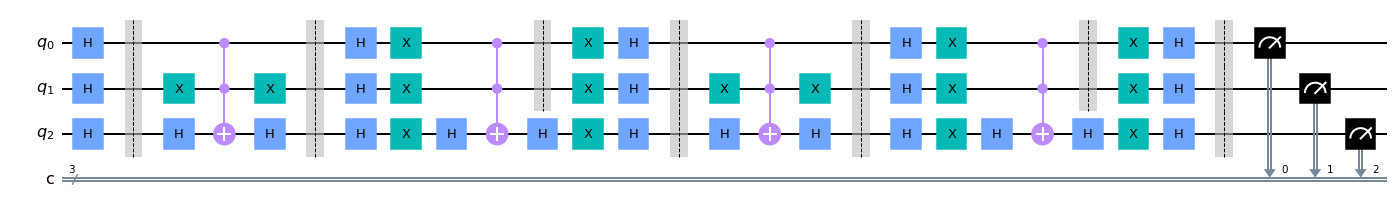

In [5]:
qreg = QuantumRegister(nqubits, 'q')
creg = ClassicalRegister(nqubits, 'c')
qc = QuantumCircuit(qreg, creg)

for i in range(nqubits):
    qc.h(qreg[i])

qc.barrier()

loops = 0;
max_loops = round((pi/4)*((2**nqubits)**0.5)-0.5)

while(loops<max_loops):
    Oracle(qc,solution,nqubits)
    Diffuser(qc,nqubits)
    loops+=1

for i in range(nqubits):
    qc.measure(qreg[i], creg[i])

qc.draw(fold=-1)

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


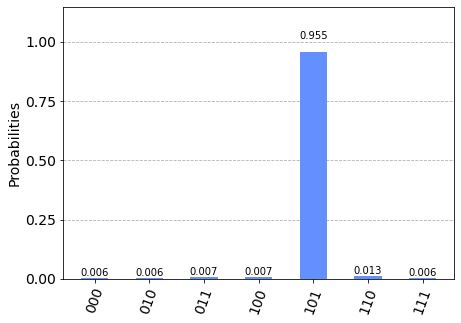

In [6]:
platform = Aer.get_backend('qasm_simulator')
#platform = provider.get_backend('ibmq_lima')
#result = execute(qc, backend=simulator, shots=1024).result()
t_qc = transpile(qc, platform)
qobj = assemble(t_qc, shots=1000)
result = platform.run(qobj).result()

plot_histogram(result.get_counts())